<a href="https://colab.research.google.com/github/luisdi97/Proyecto_PF-3347/blob/main/proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final Análisis en Ciencia de Datos

### Estudiantes

* Luis Diego Araya Campos
* Cristian Alejandro Herrera Barboza
* Josué Raúl Rivas Muñoz

## 1. Selección del Dataset
Este dataset ha sido seleccionado debido a su relevancia en el contexto de la planificación energética y su aplicabilidad en la creciente adopción de energías renovables, especialmente la energía solar. Dado que uno de los integrantes del grupo tiene acceso a la información requerida, se analiza como una excelente opción la creación de un modelo de aprendizaje que permita optimizar procesos y ayudar en la toma de decisiones que podrían fomentar la eficiencia energética y la sostenibilidad en comunidades locales.

## 2. Descripción del Problema

### Contexto del problema
En el contexto de la transición hacia energías renovables, como la solar, el análisis de la capacidad de instalación de paneles solares en distintos puntos de una red eléctrica es crucial para optimizar el consumo y la generación de energía sostenible. Sin embargo, esta capacidad no es uniforme y depende de varios factores de la red, tales como la capacidad del transformador, la carga actual en kVA, la distancia de los puntos de carga respecto a la subestación y al transformador, entre otros.

Para determinar la viabilidad de la instalación de paneles solares, se realiza un estudio de capacidad de alojamiento mediante software especializado el cual arroja la capacidad de alojamiento para los distintos punto de la red, el cual define el límite máximo de generación que puede ser inyectada en la red sin comprometer la estabilidad del sistema ni exceder la capacidad de los componentes eléctricos, como transformadores y líneas de transmisión. Así, mediante algoritmos de aprendizaje se pretende predecir la máxima capacidad de alojamiento en kW que soportan las ubicaciones donde se pretende instalar un panel.

#### Importancia:
Resolver este problema tiene un impacto directo en la capacidad de planificación y expansión de infraestructuras de energías renovables. Al predecir las capacidades de alojamiento mediante un modelo de aprendizaje se puede agilizar el proceso ya que realizar el mismo cálculo mediante el software especializado puede tardar incluso varios días para los circuitos más grandes, de esta forma también se agiliza la planificación de la red al mostrar los puntos donde podría crecer la generación distribuida y en qué medida.
Por otro lado al permitir la integración de paneles solares de forma segura y óptima reduce la huella de carbono y promueve un uso más ecológico de los recursos eléctricos esto a mismo tiempo que se optimizan los sistemas actuales.

#### Objetivo del Análisis
El objetivo de este análisis es desarrollar un modelo predictivo que estime la capacidad de alojamiento para las distintas ubicaciones en la red en función de variables clave. Este modelo permitirá determinar la capacidad de instalación de paneles solares en cada nodo de carga, facilitando así la toma de decisiones informadas sobre la incorporación de fuentes de energía renovable en cada punto de la red. Al optimizar la asignación de estas instalaciones, se espera que se logren beneficios económicos y ambientales significativos, ayudando a reducir la dependencia de fuentes de energía no renovables y mejorando la eficiencia de la red eléctrica.

#### Supuestos iniciales
De los circuitos de la red eléctrica con datos disponibles para armar el dataset se eligieron aquellos donde no había reguladores o plantas grandes de generación privada, de manera que se simplifica el problema a resolver. Por otro lado, como se muestra en el preprocesamiento del dataset se eliminan las instancias que tienen asociados transformadores grandes o que presentaran generación distribuida por lo cual se espera que hayan pocos o ningunos outliers. De esta forma se espera que el dataset sea de baja dificultad logrando que los modelos se sintonizen de manera sencilla y presenten buenas métricas.

## 3. Preprocesamiento del Dataset
Se realiza un preprocesamiento para asegurar la consistencia, relevancia y calidad de la información, se agrega una columna extra donde se realiza un conteo del número de entradas por circuito lo cual representa el número de clientes monofásicos del circuito y da una idea del tamaño del circuito que es un aspecto que afecta los resultados del análisis de capacidad de alojamiento, para ello se agrupan las instancias por el identificador de la red (Network Id).
Se seleccionaron únicamente las filas donde la generación distribuida es igual a 0.0, es decir, aquellas sin generación adicional en las cargas para simplificar el modelo ya que si ya existe generación distribuida en el punto la generación adicional arrojada por el software especializado es menor.
Además se deben filtrar las filas para excluir cualquier valor de carga negativo o inválido ('Load (kVA)' >= 0.0). Esto garantiza que solo se consideren valores positivos y realistas de carga, lo que mejora la precisión del modelo.
Como dato adicional es importante restringir el dataset a transformadores con una capacidad máxima de 50 kVA, para centrar el análisis en transformadores de menor capacidad, típicos de instalaciones residenciales o comerciales pequeñas. Este enfoque asegura que el modelo se optimice para escenarios en los que la carga y la capacidad son limitadas, ya que los de mayor capacidad pueden generar ruido en los datos y bajar la precisión del modelo.
Las features más relevantes seleccionadas permiten mejorar los resultados, incluyendo capacidad del transformador, impedancia, carga en kVA, número de nodos de carga, y distancias de conexión (del punto a la subestación y del punto al transformador). Estas variables permiten al modelo aprender patrones importantes para la predicción de la capacidad de carga de la red.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('datos_IA_ICA.csv')
df

,Network Id,IC Max per Load (kW),Constraint per Load,IC Volt Variation MT (kW),IC Volt Variation BT (kW),IC Voltage Unbalance (kW),IC Volt Limits (kW),IC Loading (kW),IC Fault Current Variation (kW),OBJECTID Transformer,...,Distributed Generation per Load (kW),IC Max per Transfomer (kW),Constraint per Transformer,Transformer Load (kVA),Number of Load Nodes,Distributed Generation per Transformer (kW),Distance from substation to Load (m),Distance from transformer to Load (m),Max distance from transformer to Load (m),IC Prot Reach (kW)
0,0,66.227012,IC Loading (kW),92.834901,100.000000,100.0,100.000000,66.227012,NaN,1757500_T,...,0.00,66.227012,IC Loading (kW),46.701847,1,0.00,6231.403964,0.0,0.0,NaN
1,0,39.338502,IC Loading (kW),44.136866,76.979637,100.0,55.816274,39.338502,NaN,1570287_T,...,0.00,39.338502,IC Loading (kW),15.867834,1,0.00,6299.541223,0.0,0.0,NaN
2,0,32.842440,IC Loading (kW),42.906003,74.829132,100.0,76.850072,32.842440,NaN,1570288_T,...,0.00,32.842440,IC Loading (kW),23.350922,1,0.00,6300.676739,0.0,0.0,NaN
3,0,32.842441,IC Loading (kW),42.897159,74.813462,100.0,76.875324,32.842441,NaN,3543374_T,...,0.00,32.842441,IC Loading (kW),23.350922,1,0.00,6366.654858,0.0,0.0,NaN
4,0,13.608194,IC Loading (kW),18.157137,31.730709,100.0,19.124799,13.608194,NaN,300380_T,...,0.00,13.608194,IC Loading (kW),4.294494,1,0.00,9189.457160,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83561,29,95.966316,IC Loading (kW),1000.000000,422.193711,NaN,539.364952,95.966316,186.555865,894463_T,...,0.00,95.966316,IC Loading (kW),45.856394,2,0.00,11443.200000,8.8,8.8,NaN
83562,29,133.749377,IC Loading (kW),1000.000000,450.027015,NaN,609.635581,133.749377,187.517309,894463_T,...,0.00,95.966316,IC Loading (kW),45.856394,2,0.00,11442.100000,7.7,8.8,NaN
83563,29,247.742728,IC Loading (kW),1000.000000,1000.000000,NaN,490.543335,247.742728,287.550202,894465_T,...,0.00,247.742728,IC Loading (kW),103.115261,1,0.00,17169.400000,2.8,2.8,NaN
83564,29,14.863747,IC Loading (kW),1000.000000,553.675056,NaN,579.989884,14.863747,181.518313,894464_T,...,105.05,14.863747,IC Loading (kW),29.009023,1,105.05,17001.700000,2.5,2.5,NaN


In [3]:
df_final = df.copy()

# Se agrega una columna nueva con el número de datos por circuito
df_final['Num_Nodos_Load'] = df_final.groupby('Network Id')['Network Id'].transform('count')

In [4]:
# Se seleccionan solo las instancias donde no hay generación distribuida
df_final = df_final.loc[df_final['Distributed Generation per Load (kW)'] == 0.0].copy()

In [5]:
# Se seleccionan solo las instancias donde la carga es positiva
df_final = df_final.loc[df_final['Load (kVA)'] >= 0.0].copy()

In [6]:
# Se imprimen los valores de capacidad de trasformadores
kVA_transformers = list(df_final['Transformer Capacity (kVA)'].unique())
kVA_transformers.sort()
kVA_transformers

[np.float64(10.0),
 np.float64(15.0),
 np.float64(20.0),
 np.float64(25.0),
 np.float64(30.0),
 np.float64(32.5),
 np.float64(35.0),
 np.float64(37.5),
 np.float64(40.0),
 np.float64(45.0),
 np.float64(50.0),
 np.float64(52.5),
 np.float64(55.0),
 np.float64(60.0),
 np.float64(62.5),
 np.float64(65.0),
 np.float64(75.0),
 np.float64(85.0),
 np.float64(87.5),
 np.float64(100.0),
 np.float64(110.0),
 np.float64(112.5),
 np.float64(113.0),
 np.float64(115.0),
 np.float64(125.0),
 np.float64(137.5),
 np.float64(150.0),
 np.float64(160.0),
 np.float64(167.0),
 np.float64(175.0),
 np.float64(185.0),
 np.float64(200.0),
 np.float64(225.0),
 np.float64(250.0),
 np.float64(300.0),
 np.float64(310.0),
 np.float64(400.0),
 np.float64(500.0),
 np.float64(501.0),
 np.float64(511.0),
 np.float64(750.0),
 np.float64(999.0),
 np.float64(1000.0),
 np.float64(1500.0),
 np.float64(2000.0),
 np.float64(2500.0),
 np.float64(3000.0)]

In [7]:
# Se seleccionan solo las instancias con transformador de capacidad menor o igual a 50 kVA, para evitar outliers
df_final = df_final.loc[df_final['Transformer Capacity (kVA)'] <= 50.0].copy()

In [8]:
# Verifico que no hayan valores nulos, en las columnas que se utilizarán para el análisis:
print(
    df_final[
        [
            'Transformer Capacity (kVA)',
            'Total Path Z (Ω)',
            'Load (kVA)',
            'Number of Load Nodes',
            'Distance from substation to Load (m)',
            'Distance from transformer to Load (m)',
            'Num_Nodos_Load','IC Max per Load (kW)',
        ]
    ].isnull().sum()
)

duplicated_rows = df_final.duplicated()
# Mostrar todas las filas duplicadas si existen
df_final[duplicated_rows]

Transformer Capacity (kVA)               0
Total Path Z (Ω)                         0
Load (kVA)                               0
Number of Load Nodes                     0
Distance from substation to Load (m)     0
Distance from transformer to Load (m)    0
Num_Nodos_Load                           0
IC Max per Load (kW)                     0
dtype: int64


,Network Id,IC Max per Load (kW),Constraint per Load,IC Volt Variation MT (kW),IC Volt Variation BT (kW),IC Voltage Unbalance (kW),IC Volt Limits (kW),IC Loading (kW),IC Fault Current Variation (kW),OBJECTID Transformer,...,IC Max per Transfomer (kW),Constraint per Transformer,Transformer Load (kVA),Number of Load Nodes,Distributed Generation per Transformer (kW),Distance from substation to Load (m),Distance from transformer to Load (m),Max distance from transformer to Load (m),IC Prot Reach (kW),Num_Nodos_Load


In [9]:
# Se imprime la descrición de los datos con los que contamos
df_final.describe()

,Network Id,IC Max per Load (kW),IC Volt Variation MT (kW),IC Volt Variation BT (kW),IC Voltage Unbalance (kW),IC Volt Limits (kW),IC Loading (kW),IC Fault Current Variation (kW),Transformer Capacity (kVA),Total Path R (Ω),...,Distributed Generation per Load (kW),IC Max per Transfomer (kW),Transformer Load (kVA),Number of Load Nodes,Distributed Generation per Transformer (kW),Distance from substation to Load (m),Distance from transformer to Load (m),Max distance from transformer to Load (m),IC Prot Reach (kW),Num_Nodos_Load
count,78874.000000,78874.000000,44291.000000,64813.000000,26084.000000,78874.000000,78874.000000,16860.000000,78874.000000,78874.000000,...,78874.0,78874.000000,78874.000000,78874.000000,78874.000000,78874.000000,78874.000000,78874.000000,143.000000,78874.000000
mean,15.089801,14.464479,398.150456,28.196298,146.938880,18.321903,29.199188,111.927309,33.394116,0.025816,...,0.0,8.853498,13.365612,36.433945,0.235691,8338.843016,79.160900,155.614716,165.914297,11620.933996
std,10.491261,6.826073,457.746878,108.726261,100.935905,11.091508,23.381465,57.456808,15.331889,0.029364,...,0.0,5.161798,9.431816,22.230790,1.920446,5967.273500,59.469581,80.285128,59.771078,5074.972875
min,0.000000,0.000000,0.000008,0.552629,25.000000,0.316605,0.000000,1.412488,10.000000,0.000000,...,0.0,0.000000,-9.527180,1.000000,0.000000,95.653982,0.000000,0.000000,14.418919,11.000000
25%,3.000000,10.100000,100.000000,12.776153,100.000000,11.497769,18.263682,65.601447,25.000000,0.013842,...,0.0,5.958652,6.931338,21.000000,0.000000,3990.004026,35.900000,104.200000,166.994083,9043.000000
50%,17.000000,14.625825,200.000000,18.711324,100.000000,16.457898,19.859683,102.748763,25.000000,0.020141,...,0.0,8.600000,11.094322,34.000000,0.000000,6425.417874,64.900000,140.500000,200.000000,11910.000000
75%,27.000000,18.211141,433.959961,27.526867,100.000000,22.884367,22.079200,149.432343,50.000000,0.027550,...,0.0,11.300000,17.480326,48.000000,0.000000,11863.817472,107.400000,194.600000,200.000000,14593.000000
max,29.000000,97.578440,3000.000000,4577.688918,1000.000000,203.103403,353.240967,417.832079,50.000000,1.204620,...,0.0,97.578440,49.509482,184.000000,50.000000,36350.731352,1153.800000,1153.800000,200.000000,18157.000000


In [10]:
# Se imprime el dataset
df_final

,Network Id,IC Max per Load (kW),Constraint per Load,IC Volt Variation MT (kW),IC Volt Variation BT (kW),IC Voltage Unbalance (kW),IC Volt Limits (kW),IC Loading (kW),IC Fault Current Variation (kW),OBJECTID Transformer,...,IC Max per Transfomer (kW),Constraint per Transformer,Transformer Load (kVA),Number of Load Nodes,Distributed Generation per Transformer (kW),Distance from substation to Load (m),Distance from transformer to Load (m),Max distance from transformer to Load (m),IC Prot Reach (kW),Num_Nodos_Load
0,0,66.227012,IC Loading (kW),92.834901,100.000000,100.0,100.000000,66.227012,NaN,1757500_T,...,66.227012,IC Loading (kW),46.701847,1,0.0,6231.403964,0.0,0.0,NaN,842
1,0,39.338502,IC Loading (kW),44.136866,76.979637,100.0,55.816274,39.338502,NaN,1570287_T,...,39.338502,IC Loading (kW),15.867834,1,0.0,6299.541223,0.0,0.0,NaN,842
2,0,32.842440,IC Loading (kW),42.906003,74.829132,100.0,76.850072,32.842440,NaN,1570288_T,...,32.842440,IC Loading (kW),23.350922,1,0.0,6300.676739,0.0,0.0,NaN,842
3,0,32.842441,IC Loading (kW),42.897159,74.813462,100.0,76.875324,32.842441,NaN,3543374_T,...,32.842441,IC Loading (kW),23.350922,1,0.0,6366.654858,0.0,0.0,NaN,842
4,0,13.608194,IC Loading (kW),18.157137,31.730709,100.0,19.124799,13.608194,NaN,300380_T,...,13.608194,IC Loading (kW),4.294494,1,0.0,9189.457160,0.0,0.0,NaN,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83545,29,1.412488,IC Fault Current Variation (kW),1000.000000,68.665465,NaN,66.413684,42.312307,1.412488,2720440_T,...,1.412488,IC Fault Current Variation (kW),0.000000,3,0.0,11600.000000,4.1,4.1,NaN,18157
83546,29,31.310848,IC Loading (kW),1000.000000,63.075676,NaN,60.435768,31.310848,140.001965,2720440_T,...,1.412488,IC Fault Current Variation (kW),0.000000,3,0.0,11597.900000,2.0,4.1,NaN,18157
83547,29,57.788939,IC Volt Variation BT (kW),1000.000000,57.788939,NaN,92.684883,74.334808,137.706260,2720435_T,...,57.788939,IC Volt Variation BT (kW),30.151610,1,0.0,11296.100000,8.1,8.1,NaN,18157
83548,29,29.221530,IC Volt Limits (kW),1000.000000,37.569792,NaN,29.221530,33.540510,124.356774,2600762_T,...,25.890211,IC Volt Limits (kW),1.990006,2,0.0,7076.200000,14.1,18.3,NaN,18157


In [11]:
# Se definen los features y el target

features = [
    'Transformer Capacity (kVA)',
    'Total Path Z (Ω)',
    'Load (kVA)',
    'Number of Load Nodes',
    'Distance from substation to Load (m)',
    'Distance from transformer to Load (m)',
    'Num_Nodos_Load',
]

target = 'IC Max per Load (kW)'

Continuando con el preprosesamiento de los datos, se aplica un algoritmo de detección de anomalías basado en árboles de decisión llamado Isolation Forest. El objetivo es es identificar datos atípicos mediante la partición iterativa del espacio de características, este algoritm funciona aislando puntos de datos utilizando divisiones aleatorias y midiendo la profundidad promedio de estas particiones.


In [12]:
# Imprimo la media:
df_num_features = df_final[['Transformer Capacity (kVA)',
            'Total Path Z (Ω)',
            'Load (kVA)',
            'Number of Load Nodes',
            'Distance from substation to Load (m)',
            'Distance from transformer to Load (m)',
            'Num_Nodos_Load','IC Max per Load (kW)'
            ]]
mean_values_selected = df_num_features.mean()

print(mean_values_selected)

Transformer Capacity (kVA)                  33.394116
Total Path Z (Ω)                             0.026869
Load (kVA)                                   0.513431
Number of Load Nodes                        36.433945
Distance from substation to Load (m)      8338.843016
Distance from transformer to Load (m)       79.160900
Num_Nodos_Load                           11620.933996
IC Max per Load (kW)                        14.464479
dtype: float64


In [13]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05)  # 5% de anomalías esperadas
anomaly_labels = iso.fit_predict(df_num_features)

# Filtrar anomalías
anomalies = df_num_features[anomaly_labels == -1]
print(anomalies)

       Transformer Capacity (kVA)  Total Path Z (Ω)  Load (kVA)  \
0                            50.0          0.000000   46.701847   
1                            25.0          0.000000   15.867834   
2                            25.0          0.000000   23.350922   
3                            25.0          0.000000   23.350922   
4                            10.0          0.000000    4.294494   
...                           ...               ...         ...   
83308                        15.0          0.081757    0.344032   
83310                        15.0          0.092500    0.266405   
83312                        15.0          0.150154    0.227591   
83462                        50.0          0.083801    1.105550   
83547                        50.0          0.009458   30.151610   

       Number of Load Nodes  Distance from substation to Load (m)  \
0                         1                           6231.403964   
1                         1                           629

Este preprocesamiento arrojó un total de 3944 resultados, pero al compararlos con la media, en realidad son datos que se alejan un poco de la media, pero siguen siendo valores importantes para el entrenamiento, por lo que se decide no excluirlos del dataset y continuar con el entrenamiento haciendo uso de los mismos.

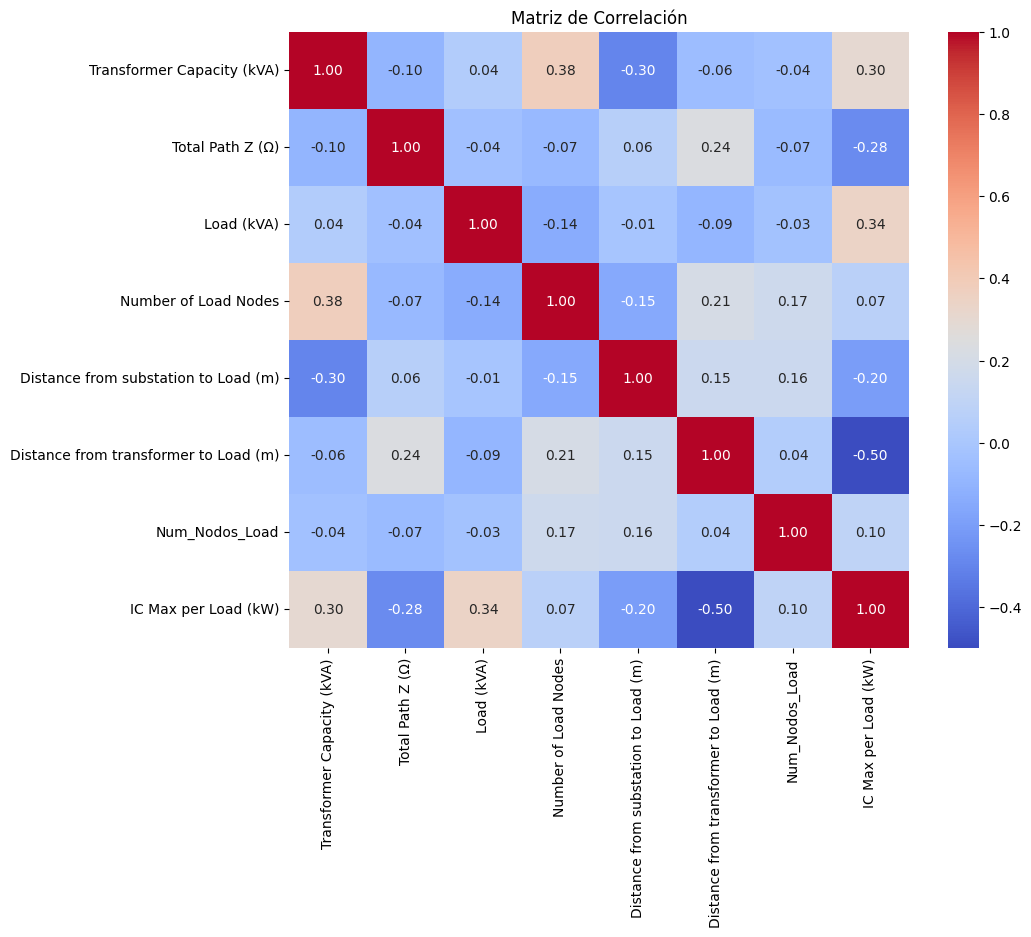

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Con los valores obtenidos y para un mejor análisis se crea una matriz de correlación
# Crear una matriz de correlación
correlacion = df_final[[
    'Transformer Capacity (kVA)',
    'Total Path Z (Ω)',
    'Load (kVA)',
    'Number of Load Nodes',
    'Distance from substation to Load (m)',
    'Distance from transformer to Load (m)',
    'Num_Nodos_Load',
    'IC Max per Load (kW)'
]].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

En general las correlaciones son bajas por lo que todos los features son relevantes para la creación del modelo de aprendizaje.

In [15]:
# Se definen las entradas y salidas para entrenar y probar los modelos
X = df_final.loc[:, features].copy()
y = df_final.loc[:, target].copy()

## Prueba de implementación de algoritmo de regresión lineal

### Linear Support Vector Regression

In [16]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error

# Separación de subconjuntos para entrenamiento y pruebas.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Parámetros iniciales

params_svr = {
    # epsilon=0.0,
    # tol=0.0001,
    # C=1.0,
    # loss='epsilon_insensitive',
    # fit_intercept=True,
    # intercept_scaling=1.0,
    # dual='auto',
    # verbose=0,
    # random_state=None,
    # max_iter=1000,
}

In [ ]:
# Crear el modelo
linear_reg = LinearSVR(**params_svr)

# Entrenar el modelo
linear_reg.fit(X_train, y_train)

In [ ]:
# Realizar predicciones
y_pred_linear = linear_reg.predict(X_test)

In [ ]:
# Calcular las métricas
mse = mean_squared_error(y_test, y_pred_linear)
rmse = root_mean_squared_error(y_test, y_pred_linear)
r2 = r2_score(y_test, y_pred_linear)

# Obtener el Training Score (R² en el conjunto de entrenamiento)
train_score = linear_reg.score(X_train, y_train)

# Obtener el Testing Score (R² en el conjunto de prueba)
test_score = linear_reg.score(X_test, y_test)

# Calculo del MAE
mae_linear = mean_absolute_error(y_test, y_pred_linear)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')
print(f"Training Score (R²): {train_score}")
print(f"Testing Score (R²): {test_score}")
print(f"MAE: {mae_linear}")

Dada la forma de los datos utilizados, al utilizar un kernel lineal para la regresión, el algoritmo es incapaz de converger correctamente y dar valores de error y puntuaciones safistactorias. De hecho se puede notar en la celda anterior que estas métricas son bastante malas, aún haciendo pruebas con otros hiper-parámetros en el algortimo.

Por esta razón, a continuación se exploran diferentes algoritmos no lineales que logren mejores resultados.

## Implementación de KNN

### Prueba inicial para KNN

In [ ]:
# Para el uso de KNN es necesario normalizar las características:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
# Librerías
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import timeit

In [ ]:
# División del dataset en entrenamiento y prueba para KNN. Es diferente de los demás algoritmos, ya que en este se usa el X escalado
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Verificar los tamaños de los conjuntos
print(f"Conjunto de entrenamiento: {X_train_knn.shape}")
print(f"Conjunto de prueba: {X_test_knn.shape}")

In [ ]:
# Crear el modelo KNN
knn = KNeighborsRegressor(n_neighbors=5)  # Este es el hiperparámetro que se ajusta en KNN idealmente inicia en 5

# Entrenar el modelo
knn.fit(X_train_knn, y_train_knn)

# Realizar predicciones
knn_y_pred = knn.predict(X_test_knn)

In [ ]:
# Análisis de las métricas
mse_knn = mean_squared_error(y_test_knn, knn_y_pred)
rmse_knn = root_mean_squared_error(y_test_knn, knn_y_pred)
r2_knn = r2_score(y_test_knn, knn_y_pred)

print(f'Mean Squared Error: {mse_knn}')
print(f'Root Mean Squared Error: {rmse_knn}')
print(f'R^2 Score: {r2_knn}')

# Obtener el Training Score (R² en el conjunto de entrenamiento)
train_score_knn = knn.score(X_train_knn, y_train_knn)

# Obtener el Testing Score (R² en el conjunto de prueba)
test_score_knn = knn.score(X_test_knn, y_test_knn)

# Calculo del MAE
mae_knn = mean_absolute_error(y_test_knn, knn_y_pred)

print(f"Training Score (R²): {train_score_knn}")
print(f"Testing Score (R²): {test_score_knn}")

print(f"MAE: {mae_knn}")

### Optimización de los hiperparámetros
Se determina que deben haber mejores hiperparámetros, por lo que se intenta revisar cual es el mejor numero de vecinos (n_neighbors). Para esto se hace un análisis desde 1 hasta 21:

In [ ]:
scores = []
train_scores = []
test_scores = []

# Probar diferentes valores de n_neighbors
for k in range(1, 21):
    knn = KNeighborsRegressor(n_neighbors=k)
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(knn, X_train_knn, y_train_knn, cv=5, scoring='neg_root_mean_squared_error')

    knn.fit(X_train_knn, y_train_knn)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(knn.score(X_train_knn, y_train_knn))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(knn.score(X_test_knn, y_test_knn))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de n_neighbors con el menor error
best_k = np.argmin(scores) + 1
print(f"Mejor valor de n_neighbors: {best_k}")

# Graficar los puntajes
plt.plot(range(1, 21), scores)
plt.xlabel('Número de vecinos (n_neighbors)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Número de vecinos vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range(1, 21), test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Número de vecinos (n_neighbors)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a n_neighbors')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Ahora se harán pruebas variando otros hiperámetros del algoritmo, en especial la función de pesos usada en la predicción.
El valor defaul es "uniform". Ahora se probará con "distance".

In [ ]:
import tracemalloc
tracemalloc.start()

knn = KNeighborsRegressor(n_neighbors=3, weights='distance')  # Se ajusta el hiperparámetro "weights" para ver las diferencias.

# Ajusto los modelos a funcions, esto con el fin de poder obtener un tiempo de ejecución tanto para el entrenamiento como para la predicción
# Entrenar el modelo
def train_model():
    knn.fit(X_train_knn, y_train_knn)


# Realizar predicciones
def predict_model():
    global knn_y_pred_t
    knn_y_pred_t = knn.predict(X_test_knn)

train_time_knn = timeit.timeit(train_model, number=1)
print(f"Tiempo de entrenamiento: {train_time_knn:.2f} segundos")

predict_time_knn = timeit.timeit(predict_model, number=1)
print(f"Tiempo de predicción: {predict_time_knn:.2f} segundos")


memoria_knn, peak_knn = tracemalloc.get_traced_memory()
print(f"Uso de memoria actual: {memoria_knn / 10**6:.2f} MB")
print(f"Pico de uso de memoria: {peak_knn / 10**6:.2f} MB")
tracemalloc.stop()

mse = mean_squared_error(y_test_knn, knn_y_pred_t)
rmse = root_mean_squared_error(y_test_knn, knn_y_pred_t)
r2 = r2_score(y_test_knn, knn_y_pred_t)

# Obtener el Training Score (R² en el conjunto de entrenamiento)
train_score = knn.score(X_train_knn, y_train_knn)
# Obtener el Testing Score (R² en el conjunto de prueba)
test_score = knn.score(X_test_knn, y_test_knn)
# Calculo del MAE
mae_knn = mean_absolute_error(y_test_knn, knn_y_pred_t)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')
print(f"Training Score (R²): {train_score}")
print(f"Testing Score (R²): {test_score}")
print(f"MAE: {mae_knn}")

Como los resultados muestran un claro overfitting para la puntuación de entranamiento, se desecha la idea de utilizar la función "distance" para el cálculo de pesos y se retorna al valor default.

### Medición de Métricas

El resultado del análisis indica que el mejor numero de vecinos es 3, por lo que se ejecuta el algoritmo con este valor y se vuelven a imprimir las metricas


In [ ]:
import tracemalloc
tracemalloc.start()

knn = KNeighborsRegressor(n_neighbors=3)  # Este es el hiperparámetro que se ajusta en KNN idealmente inicia en 5

# Ajusto los modelos a funciones, esto con el fin de poder obtener un tiempo de ejecución tanto para el entrenamiento como para la predicción
# Entrenar el modelo
def train_model():
    knn.fit(X_train_knn, y_train_knn)

# Realizar predicciones
def predict_model():
    global knn_y_pred_t
    knn_y_pred_t = knn.predict(X_test_knn)

train_time_knn = timeit.timeit(train_model, number=1)
print(f"Tiempo de entrenamiento: {train_time_knn:.2f} segundos")

predict_time_knn = timeit.timeit(predict_model, number=1)
print(f"Tiempo de predicción: {predict_time_knn:.2f} segundos")

memoria_knn, peak_knn = tracemalloc.get_traced_memory()
print(f"Uso de memoria actual: {memoria_knn / 10**6:.2f} MB")
print(f"Pico de uso de memoria: {peak_knn / 10**6:.2f} MB")
tracemalloc.stop()

mse_knn_final = mean_squared_error(y_test_knn, knn_y_pred_t)
rmse_knn_final = root_mean_squared_error(y_test_knn, knn_y_pred_t)
r2_knn_final = r2_score(y_test_knn, knn_y_pred_t)

# Obtener el Training Score (R² en el conjunto de entrenamiento)
train_score_knn_final = knn.score(X_train_knn, y_train_knn)
# Obtener el Testing Score (R² en el conjunto de prueba)
test_score_knn_final = knn.score(X_test_knn, y_test_knn)
# Calculo del MAE
mae_knn_final = mean_absolute_error(y_test_knn, knn_y_pred_t)

print(f'Mean Squared Error: {mse_knn_final}')
print(f'Root Mean Squared Error: {rmse_knn_final}')
print(f'R^2 Score: {r2_knn_final}')
print(f"Training Score (R²): {train_score_knn_final}")
print(f"Testing Score (R²): {test_score_knn_final}")
print(f"MAE: {mae_knn_final}")

In [ ]:
# Con los datos obtenidos se imprimen los resultados:
# Valores de R²
scores = [train_score_knn_final, test_score_knn_final]
labels = ['Training Score', 'Testing Score']

# Convertir a porcentaje
scores_percentage = [score * 100 for score in scores]

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(labels, scores_percentage, color=['blue', 'orange'])
plt.ylim(0, 100)  # Rango de porcentaje
plt.ylabel('R² Score (%)')
plt.title('Comparación de R² Scores')
plt.grid(axis='y', linestyle='--')

# Formatear etiquetas en el eje y como porcentaje
plt.yticks(ticks=np.arange(0, 101, 10), labels=[f'{int(tick)}%' for tick in np.arange(0, 101, 10)])

plt.show()

In [ ]:
# se realiza un análisis de la predicción de los valores:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_knn, knn_y_pred_t, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

In [ ]:
# Entrenamiento para los demás modelos.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Implementación de Random Forest

### Prueba inicial para Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [19]:
# Crear el modelo

rf = RandomForestRegressor(n_estimators=100, random_state=42)
#tracemalloc.start()

# Entrenar el modelo
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

#train_time_rf = timeit.timeit(train_model, number=1)
#print(f"Tiempo de entrenamiento: {train_time_rf:.2f} segundos")

#predict_time_rf = timeit.timeit(predict_model, number=1)
#print(f"Tiempo de predicción: {predict_time_rf:.2f} segundos")

#memoria_rf, peak_rf = tracemalloc.get_traced_memory()
#print(f"Uso de memoria actual: {memoria_rf / 10**6:.2f} MB")
#print(f"Pico de uso de memoria: {peak_rf / 10**6:.2f} MB")
#tracemalloc.stop()



In [20]:
# Se calculan las metricas del Random Forest.

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Obtener el Training Score (R² en el conjunto de entrenamiento)
train_score_rf = rf.score(X_train, y_train)

# Obtener el Testing Score (R² en el conjunto de prueba)
test_score_rf = rf.score(X_test, y_test)

# Calculo del MAE
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Imprimir los resultados
print(f'Mean Squared Error: {mse_rf}')
print(f'Root Mean Squared Error: {rmse_rf}')
print(f'R^2 Score: {r2_rf}')
print(f"Training Score (R²): {train_score_rf}")
print(f"Testing Score (R²): {test_score_rf}")
print(f"MAE: {mae_rf}")

Mean Squared Error: 5.749554407971958
Root Mean Squared Error: 2.3978228474956107
R^2 Score: 0.8761493529890954
Training Score (R²): 0.9811736633575577
Testing Score (R²): 0.8761493529890954
MAE: 1.283374780005728


### Optimización de los Hiperparámetros

Se probarán diferentes valores de n_estimators para encontrar el óptimo.

Mejor valor de n_estimators: 200


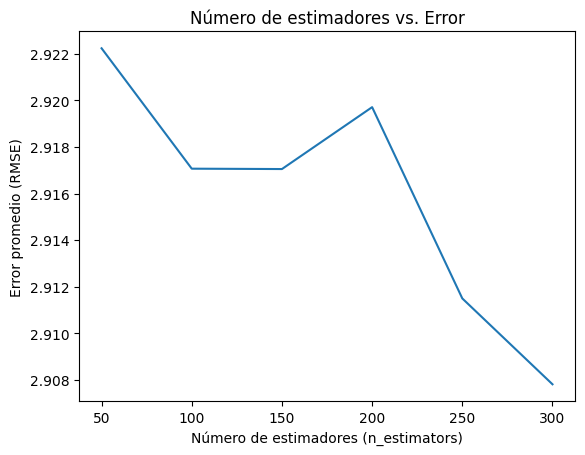

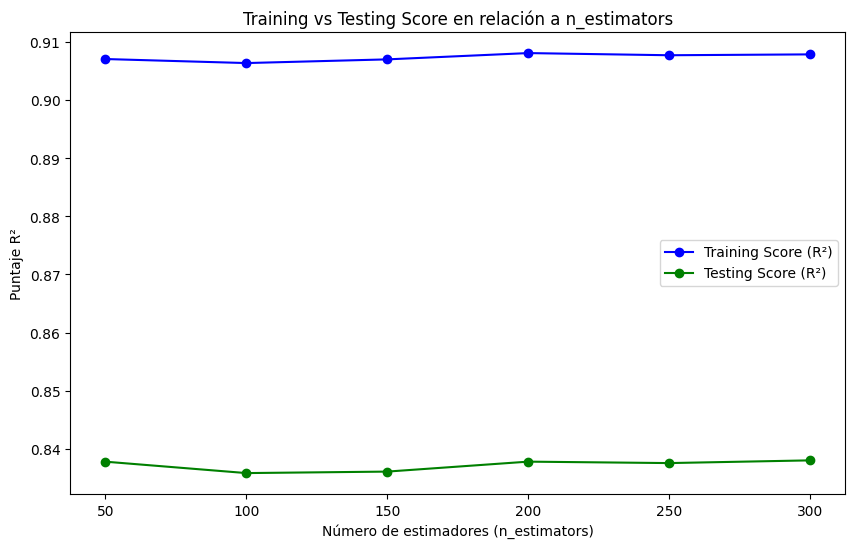

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

scores = []
train_scores = []
test_scores = []

range_test = range(95, 115, 1)

# Probar diferentes valores de n_estimators
for n in range_test:
    rf = RandomForestRegressor(n_estimators=n, max_depth=15)

    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    rf.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(rf.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(rf.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de n_estimators con el menor error
best_n = 10 + np.argmin(scores)*38
print(f"Mejor valor de n_estimators: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Número de estimadores (n_estimators)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Número de estimadores vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Número de estimadores (n_estimators)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a n_estimators')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Para mejorar los resultados se realiza una busqueda de Grid Search para encontrar los mejores parámetros.


In [ ]:
# Mejores parámetros encontrados: {'n_estimators': 184, 'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}

# Definir los parámetros a probar
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

rf = RandomForestRegressor(random_state=42) # n_estimators=10 da un muy buen resultado ;Mean Squared Error (Random Forest): 40.11068269701386 y R² Score (Random Forest): 0.902790660423813
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=10,
)

# Entrenar el modelo
grid_search.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
print("Mejores parámetros encontrados:", grid_search.best_params_)

El resultado del Grid Search indica:
Mejores parámetros encontrados: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Por lo que se ejecuta el algoritmo con dichos parámetros

Como siguiete paso después del grid search se implementa una busqueda de parámetros con una optimización Bayesiana, esto con el objetivo de comparar los resultados obtenidos con el grid search y encontrar aún mejores hiper parámetros

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score


def objective(trial):
    # Definir el espacio de búsqueda
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_categorical('max_depth', [None] + list(range(1, 51)))
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])

    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Validación cruzada
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    return -scores.mean()

# Ejecutar la optimización
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [ ]:
# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", study.best_params)

La búsqueda Vayeciana da como resultado los siguientes parámetros a utilizar :
Mejores parámetros encontrados: {'n_estimators': 184, 'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}
Luego se procede a ejecutar tanto con los parámetros encontrados por la busqueda bayeciana, como por gridsearch

In [ ]:
best_rf = RandomForestRegressor(
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

def train_model():
    best_rf.fit(X_train, y_train)

def predict_model():
    global y_pred_grid_rf
    y_pred_grid_rf = best_rf.predict(X_test)

train_time_grid_rf = timeit.timeit(train_model, number=1)
print(f"Tiempo de entrenamiento: {train_time_grid_rf:.2f} segundos")

predict_time_grid_rf = timeit.timeit(predict_model, number=1)
print(f"Tiempo de predicción: {predict_time_grid_rf:.2f} segundos")

# Evaluar el modelo
mse_grid_rf = mean_squared_error(y_test, y_pred_grid_rf)
rmse_grid_rf = root_mean_squared_error(y_test, y_pred_grid_rf)
r2_grid_rf = r2_score(y_test, y_pred_grid_rf)

train_score_grid_rf = best_rf.score(X_train, y_train)

test_score_grid_rf = best_rf.score(X_test, y_test)

mae_grid_rf = mean_absolute_error(y_test, y_pred_grid_rf)
print(f'Mean Squared Error (Mejor Random Forest): {mse_grid_rf}')
print(f'Root Mean Squared Error (Mejor Random Forest): {rmse_grid_rf}')
print(f'R² Score (Mejor Random Forest): {r2_grid_rf}')
print(f"Training Score (R²): {train_score_grid_rf}")
print(f"Testing Score (R²): {test_score_grid_rf}")
print(f"MAE: {mae_grid_rf}")

In [ ]:
# Mejores parámetros encontrados: con busqueda bayeciana {'n_estimators': 184, 'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}

bayeciana_rf = RandomForestRegressor(
    max_depth=48,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=185,
    random_state=42
)
def train_model():
    bayeciana_rf.fit(X_train, y_train)

def predict_model():
    global y_pred_bayeciana_rf
    y_pred_bayeciana_rf = bayeciana_rf.predict(X_test)

train_time_bayeciana_rf = timeit.timeit(train_model, number=1)
print(f"Tiempo de entrenamiento: {train_time_bayeciana_rf:.2f} segundos")

predict_time_bayeciana_rf = timeit.timeit(predict_model, number=1)
print(f"Tiempo de predicción: {predict_time_bayeciana_rf:.2f} segundos")

# Evaluar el modelo
mse_bayeciana_rf = mean_squared_error(y_test, y_pred_bayeciana_rf)
rmse_bayeciana_rf = root_mean_squared_error(y_test, y_pred_bayeciana_rf)
r2_bayeciana_rf = r2_score(y_test, y_pred_bayeciana_rf)

train_score_bayeciana_rf = bayeciana_rf.score(X_train, y_train)

test_score_bayeciana_rf = bayeciana_rf.score(X_test, y_test)

mae_bayeciana_rf = mean_absolute_error(y_test, y_pred_bayeciana_rf)
print(f'Mean Squared Error (Mejor Random Forest): {mse_bayeciana_rf}')
print(f'Root Mean Squared Error (Mejor Random Forest): {rmse_bayeciana_rf}')
print(f'R² Score (Mejor Random Forest): {r2_bayeciana_rf}')
print(f"Training Score (R²): {train_score_bayeciana_rf}")
print(f"Testing Score (R²): {test_score_bayeciana_rf}")
print(f"MAE: {mae_bayeciana_rf}")


Con los valores del gridsearV se tiene como resultados:
Mean Squared Error (Mejor Random Forest): 5.95865748121562
Root Mean Squared Error (Mejor Random Forest): 2.4410361491005452
R² Score (Mejor Random Forest): 0.8716450820359779
Training Score (R²): 0.981951084216809
Testing Score (R²): 0.8716450820359779
MAE: 1.3488703394791421


Con la optimización Bayesiana:

Mean Squared Error (Mejor Random Forest): 5.95804402115964
Root Mean Squared Error (Mejor Random Forest): 2.440910490198205
R² Score (Mejor Random Forest): 0.8716582965252161
Training Score (R²): 0.981925068435337
Testing Score (R²): 0.8716582965252161
MAE: 1.348832000941697


In [ ]:
# Datos de puntajes
scores = {
    "Estimators=100": [train_score_rf, test_score_rf],
    "GridSearch": [train_score_grid_rf, test_score_grid_rf],
    "Bayesian Search": [train_score_bayeciana_rf, test_score_bayeciana_rf],
}

# Convertir los datos en formato para graficar
labels = list(scores.keys())  # Modelos
train_scores = [score[0] for score in scores.values()]  # Train scores
test_scores = [score[1] for score in scores.values()]  # Test scores

# Configuración del gráfico
x = np.arange(len(labels))  # Posiciones en el eje X
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

# Barras de train_score
bars1 = ax.bar(x - width/2, train_scores, width, label='Train Score', color='blue')

# Barras de test_score
bars2 = ax.bar(x + width/2, test_scores, width, label='Test Score', color='orange')

# Etiquetas y título
ax.set_xlabel('Modelos', fontsize=12)
ax.set_ylabel('Scores (R²)', fontsize=12)
ax.set_title('Comparación de Scores Random Forest: estimators=100 vs GridSearch vs Búsqueda Bayesiana', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Agregar valores encima de las barras
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Desplazamiento del texto
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Datos de RMSE
models = ['Random Forest', 'GridSearch', 'Bayesian Search']
rmse_values = [rmse_rf, rmse_grid_rf, rmse_bayeciana_rf]

# Crear el gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(models, rmse_values, color=['blue', 'orange', 'green'], alpha=0.8)

# Agregar etiquetas y título
plt.xlabel('Modelos', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Comparación de RMSE en Random Forest: estimators=100 vs GridSearch vs Búsqueda Bayesiana', fontsize=14)

# Mostrar valores encima de las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Este análisis permite determinar, que apesar de que se hizo una búsqueda exaustiva de los mejores hiperparámetros, la configuración por defecto cambiando unicamente a 100 n_estimators es la que mejores resultados ofrece.

In [ ]:
# Se grafican los resultados obtenidos para knn
# Valores de R²
scores = [train_score_rf, test_score_rf]
labels = ['Training Score', 'Testing Score']

# Convertir a porcentaje
scores_percentage = [score * 100 for score in scores]

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(labels, scores_percentage, color=['blue', 'orange'])
plt.ylim(0, 100)  # Rango de porcentaje
plt.ylabel('R² Score (%)')
plt.title('Comparación de R² Scores KNN')
plt.grid(axis='y', linestyle='--')

# Formatear etiquetas en el eje y como porcentaje
plt.yticks(ticks=np.arange(0, 101, 10), labels=[f'{int(tick)}%' for tick in np.arange(0, 101, 10)])

plt.show()

In [ ]:
# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7, color='b', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Limite de decisión')

# Etiquetas y título
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales (Random Forest)')
plt.legend()
plt.show()

In [ ]:
# Se analiza la importancia de las caracteristicas en Random Forest:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Importancia de Características (Random Forest)')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), np.array(X.columns)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## Implementación de GradientBoostingRegressor

### Prueba inicial para GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# Parámetros iniciales

params = {
    # "loss": "squared_error",
    # "learning_rate": 0.1,
    # "n_estimators": 100,
    # "subsample": 1.0,
    # "criterion": "friedman_mse",
    # "min_samples_split": 2,
    # "min_samples_leaf": 1,
    # "min_weight_fraction_leaf": 0.0,
    # "max_depth": 3,
    # "min_impurity_decrease": 0.0,
    # "init": None,
    "random_state": 42,
    # "max_features": None,
    # "alpha": 0.9,
    # "verbose": 0,
    # "max_leaf_nodes": None,
    # "warm_start": False,
    # "validation_fraction": 0.1,
    # "n_iter_no_change": None,
    # "tol": 0.0001,
    # "ccp_alpha": 0.0,
}

In [ ]:
# Crear el modelo
reg = GradientBoostingRegressor(**params)

# Entrenar el modelo
reg.fit(X_train, y_train)

# Realizar predicciones
y_pred_gbr = reg.predict(X_test)

In [ ]:
# Calcular las métricas
mse = mean_squared_error(y_test, y_pred_gbr)
rmse = root_mean_squared_error(y_test, y_pred_gbr)
r2 = r2_score(y_test, y_pred_gbr)

# Obtener el Training Score (R² en el conjunto de entrenamiento)
train_score = reg.score(X_train, y_train)

# Obtener el Testing Score (R² en el conjunto de prueba)
test_score = reg.score(X_test, y_test)

# Calculo del MAE
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')
print(f"Training Score (R²): {train_score}")
print(f"Testing Score (R²): {test_score}")
print(f"MAE: {mae_gbr}")

### Optimización de los hiperparámetros

In [ ]:
scores = []
train_scores = []
test_scores = []

range_test = range(10, 1036, 38)

# Probar diferentes valores de n_estimators
for n in range_test:
    grb = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=n,
        min_samples_split=600,
        min_samples_leaf=60,
        max_depth=5,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(grb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    grb.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(grb.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(grb.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de n_estimators con el menor error
best_n = 10 + np.argmin(scores)*38
print(f"Mejor valor de n_estimators: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Número de estimadores (n_estimators)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Número de estimadores vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Número de estimadores (n_estimators)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a n_estimators')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
scores = []
train_scores = []
test_scores = []

range_test = range(2, 1271, 47)

# Probar diferentes valores de min_samples_split
for n in range_test:
    grb = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        min_samples_split=n,
        min_samples_leaf=60,
        max_depth=5,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(grb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    grb.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(grb.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(grb.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de min_samples_split con el menor error
best_n = 2 + np.argmin(scores)*47
print(f"Mejor valor de min_samples_split: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Mínimo de muestras para partición (min_samples_split)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Mínimo de muestras para partición vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Mínimo de muestras para partición (min_samples_split)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a min_samples_split')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
scores = []
train_scores = []
test_scores = []

range_test = range(1, 136, 5)

# Probar diferentes valores de min_samples_leaf
for n in range_test:
    grb = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        min_samples_split=600,
        min_samples_leaf=n,
        max_depth=5,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(grb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    grb.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(grb.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(grb.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de min_samples_leaf con el menor error
best_n = 1 + np.argmin(scores)*5
print(f"Mejor valor de min_samples_leaf: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Mínimo de muestras por hoja (min_samples_leaf)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Mínimo de muestras por hoja vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Mínimo de muestras por hoja (min_samples_leaf)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a min_samples_leaf')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
scores = []
train_scores = []
test_scores = []

range_test = range(1, 28)

# Probar diferentes valores de max_depth
for n in range_test:
    grb = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        min_samples_split=600,
        min_samples_leaf=60,
        max_depth=n,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(grb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    grb.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(grb.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(grb.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de max_depth con el menor error
best_n = np.argmin(scores) + 1
print(f"Mejor valor de max_depth: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Máxima profundidad (max_depth)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Máxima profundidad vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Máxima profundidad (max_depth)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a max_depth')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
best_grb = GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=6,
    max_depth=27,
    random_state=42,
    max_features='sqrt',
)

best_grb.fit(X_train, y_train)

y_pred_best_grb = best_grb.predict(X_test)

# Evaluar el modelo
mse_best_grb = mean_squared_error(y_test, y_pred_best_grb)
rmse_best_grb = root_mean_squared_error(y_test, y_pred_best_grb)
r2_best_grb = r2_score(y_test, y_pred_best_grb)

train_score_best_gbr = best_grb.score(X_train, y_train)

test_score_best_gbr = best_grb.score(X_test, y_test)

mae_best_grb = mean_absolute_error(y_test, y_pred_best_grb)
print(f'Mean Squared Error (Mejor Gradient Boosting): {mse_best_grb}')
print(f'Root Mean Squared Error (Mejor Gradient Boosting): {rmse_best_grb}')
print(f'R² Score (Mejor Gradient Boosting): {r2_best_grb}')
print(f"Training Score (R²): {train_score_best_gbr}")
print(f"Testing Score (R²): {test_score_best_gbr}")
print(f"MAE: {mae_best_grb}")

In [ ]:
# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_grb, alpha=0.7, color='b', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Limite de decisión')

# Etiquetas y título
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales (Gradient Boosting)')
plt.legend()
plt.show()

In [ ]:
scores = []
train_scores = []
test_scores = []

range_test = range(2, 28)

# Probar diferentes valores de min_samples_split
for n in range_test:
    grb = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        min_samples_split=n,
        min_samples_leaf=6,
        max_depth=27,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(grb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    grb.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(grb.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(grb.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de min_samples_split con el menor error
best_n = 2 + np.argmin(scores)
print(f"Mejor valor de min_samples_split: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Mínimo de muestras para partición (min_samples_split)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Mínimo de muestras para partición vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Mínimo de muestras para partición (min_samples_split)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a min_samples_split')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
scores = []
train_scores = []
test_scores = []

range_test = range(1, 27)

# Probar diferentes valores de min_samples_leaf
for n in range_test:
    grb = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        min_samples_split=2,
        min_samples_leaf=n,
        max_depth=27,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(grb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    grb.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(grb.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(grb.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de min_samples_leaf con el menor error
best_n = 1 + np.argmin(scores)
print(f"Mejor valor de min_samples_leaf: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Mínimo de muestras por hoja (min_samples_leaf)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Mínimo de muestras por hoja vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Mínimo de muestras por hoja (min_samples_leaf)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a min_samples_leaf')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
scores = []
train_scores = []
test_scores = []

range_test = range(1, 28)

# Probar diferentes valores de max_depth
for n in range_test:
    grb = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        min_samples_split=2,
        min_samples_leaf=6,
        max_depth=n,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(grb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    grb.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(grb.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(grb.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de max_depth con el menor error
best_n = np.argmin(scores) + 1
print(f"Mejor valor de max_depth: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Máxima profundidad (max_depth)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Máxima profundidad vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Máxima profundidad (max_depth)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a max_depth')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

### Análisis de los mejores hiperparámetros

In [ ]:
# Crear el modelo
best_grb = GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=6,
    max_depth=10,
    random_state=42,
    max_features='sqrt',
)

tracemalloc.start()
# Entrenar el modelo
def train_model_gbr():
    best_grb.fit(X_train, y_train)

# Realizar predicciones
def predict_model_gbr():
    global y_pred_best_grb
    y_pred_best_grb = best_grb.predict(X_test)


train_time_gbr = timeit.timeit(train_model_gbr, number=1)
print(f"Tiempo de entrenamiento: {train_time_gbr:.2f} segundos")


predict_time_gbr = timeit.timeit(predict_model_gbr, number=1)
print(f"Tiempo de predicción: {predict_time_gbr:.2f} segundos")

memoria_gbr, peak_gbr = tracemalloc.get_traced_memory()
print(f"Uso de memoria actual: {memoria_gbr / 10**6:.2f} MB")
print(f"Pico de uso de memoria: {peak_gbr / 10**6:.2f} MB")
tracemalloc.stop()

In [ ]:
# Evaluar el modelo
mse_best_grb = mean_squared_error(y_test, y_pred_best_grb)
rmse_best_grb = root_mean_squared_error(y_test, y_pred_best_grb)
r2_best_grb = r2_score(y_test, y_pred_best_grb)

train_score_best_gbr = best_grb.score(X_train, y_train)

test_score_best_gbr = best_grb.score(X_test, y_test)

mae_best_grb = mean_absolute_error(y_test, y_pred_best_grb)

print(f'Mean Squared Error (Mejor Gradient Boosting): {mse_best_grb}')
print(f'Root Mean Squared Error (Mejor Gradient Boosting): {rmse_best_grb}')
print(f'R² Score (Mejor Gradient Boosting): {r2_best_grb}')
print(f"Training Score (R²): {train_score_best_gbr}")
print(f"Testing Score (R²): {test_score_best_gbr}")
print(f"MAE: {mae_best_grb}")

In [ ]:
# Se grafican los resultados obtenidos:
# Valores de R²
scores = [train_score_best_gbr, test_score_best_gbr]
labels = ['Training Score', 'Testing Score']

# Convertir a porcentaje
scores_percentage = [score * 100 for score in scores]

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(labels, scores_percentage, color=['blue', 'orange'])
plt.ylim(0, 100)  # Rango de porcentaje
plt.ylabel('R² Score (%)')
plt.title('Comparación de R² Scores')
plt.grid(axis='y', linestyle='--')

# Formatear etiquetas en el eje y como porcentaje
plt.yticks(ticks=np.arange(0, 101, 10), labels=[f'{int(tick)}%' for tick in np.arange(0, 101, 10)])

plt.show()

In [ ]:
# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_grb, alpha=0.7, color='b', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Limite de decisión')

# Etiquetas y título
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales (Gradient Boosting)')
plt.legend()
plt.show()

# Benchmarking

In [ ]:
# Benchmarking

import pandas as pd

# Crear el DataFrame con las métricas de los modelos
benchmark = pd.DataFrame({
    "MSE": [mse_knn_final, mse_rf, mse_best_grb],
    "RMSE": [rmse_knn_final, rmse_rf, rmse_best_grb],
    "R²": [r2_knn_final, r2_rf, r2_best_grb],
    "Train R²": [train_score_knn_final, train_score_rf, train_score_best_gbr],
    "Test R²": [test_score_knn_final, test_score_rf, test_score_best_gbr],
    "MAE": [mae_knn_final, mae_bayeciana_rf, mae_best_grb]
}, index=["KNN", "Random Forest", "Gradient Boosting"])

# Mostrar el DataFrame
print(benchmark)

In [ ]:
import matplotlib.pyplot as plt

def truncate(value, decimals=3):
    factor = 10 ** decimals
    return int(value * factor) / factor

benchmark_train_test = benchmark[['Train R²', 'Test R²']]
# Gráfico de barras para comparar todos los modelos
ax = benchmark_train_test.plot(kind="bar", figsize=(12, 6), title="Benchmarking de Modelos")
plt.ylabel("Valores")
plt.xticks(rotation=0)
plt.legend(loc="best")

# Agregar los valores encima de las barras
for p in ax.patches:
    value = truncate(p.get_height(), 3)  # Truncar a 2 decimales
    ax.annotate(
        f'{value}',  # Mostrar el valor truncado
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()

In [ ]:
benchmark_RMSE = benchmark[['RMSE']]

ax2 = benchmark_RMSE.plot(kind="bar", color=["blue", "green", "red"], figsize=(8, 5), title="Comparación de RMSE")
# Lista de colores personalizados (uno para cada barra)
colors = [ "purple", "green", "orange"]  # Expande según el número de barras

# Asignar colores a las barras, esto lo hago ya que de forma predeterminada, como todos son RMSE; todos salen en azul
for i, bar in enumerate(ax2.patches):  # Recorrer las barras
    bar.set_color(colors[i % len(colors)])  # Asignar color de forma cíclica


plt.ylabel("Mean Absolute Error")
plt.xticks(rotation=0)
ax2.legend().remove() # Como le cambié el color a las barras, la elimino, ya que no coincide con los colores
# Agregar los valores encima de las barras
for p in ax2.patches:
    
    ax2.annotate(
        f'{p.get_height():.2f}',  # Valor con 2 decimales
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom', fontsize=10
    )

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo: puntajes de entrenamiento y prueba
models = ['KNN', 'Random Forest', 'Gradient Boosting']
train_scores = [train_score, train_score_rf, train_score_best_gbr]  # Puntajes de entrenamiento
test_scores = [test_score, test_score_rf, test_score_best_gbr]      # Puntajes de prueba

# Configuración del gráfico
x = np.arange(len(models))  # Posiciones de los modelos
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, train_scores, width, label='Train Score', color='blue')
bars2 = ax.bar(x + width/2, test_scores, width, label='Test Score', color='orange')

# Etiquetas y títulos
ax.set_xlabel('Modelos', fontsize=12)
ax.set_ylabel('R² Score', fontsize=12)
ax.set_title('Comparación de Train Score vs Test Score', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Mostrar los valores encima de las barras
for bar in bars1 + bars2:
    height = bar.get_height()
    truncated_value = truncate(height, 2)  # Truncar a 2 decimales
    ax.annotate(f'{truncated_value:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Datos
models = ['KNN', 'Random Forest',  'Gradient Boosting']
train_times = [train_time_knn, train_time_rf, train_time_gbr]
predict_times = [predict_time_knn, predict_time_rf, predict_time_gbr]

In [ ]:
# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
x = np.arange(len(models))

bars_train = ax.bar(x - width/2, train_times, width, label='Train Time', color='blue')
bars_predict = ax.bar(x + width/2, predict_times, width, label='Predict Time', color='orange')

# Etiquetas y leyenda
ax.set_xlabel('Modelos', fontsize=12)
ax.set_ylabel('Tiempo (segundos)', fontsize=12)
ax.set_title('Comparación de Tiempos: Entrenamiento vs Predicción', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Agregar valores encima de las barras
for bar in bars_train + bars_predict:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos en bytes convertidos a MB
models = ['KNN', 'Random Forest', 'Gradient Boosting']
memoria = [memoria_knn / 1e6, memoria_rf / 1e6, memoria_gbr / 1e6]  # Conversión a MB
peak = [peak_knn / 1e6, peak_rf / 1e6, peak_gbr / 1e6]  # Conversión a MB

# Configuración del gráfico
x = np.arange(len(models))  # Posiciones en el eje X
width = 0.25  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))
bars_memoria = ax.bar(x - width/2, memoria, width, label='Memoria (MB)', color='blue')
bars_peak = ax.bar(x + width/2, peak, width, label='Pico de Memoria (MB)', color='orange')

# Etiquetas y títulos
ax.set_xlabel('Modelos', fontsize=12)
ax.set_ylabel('Memoria (MB)', fontsize=12)
ax.set_title('Comparación de Uso de Memoria y Pico de Memoria por Modelo', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Agregar valores encima de las barras
for bar in bars_memoria + bars_peak:
    height = bar.get_height()
    ax.annotate(f'{height:.2f} MB',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos en bytes convertidos a MB
models = ['KNN', 'Random Forest', 'Gradient Boosting']
memoria = [memoria_knn / 1e6, memoria_rf / 1e6, memoria_gbr / 1e6]  # Conversión a MB
peak = [peak_knn / 1e6, peak_rf / 1e6, peak_gbr / 1e6]  # Conversión a MB

x_labels = ['Memoria', 'Pico de Memoria']
data = np.array([memoria, peak]).T  # Transponer para representar modelos en filas

# Crear el gráfico
fig, ax = plt.subplots(figsize=(10, 6))

for i, model in enumerate(models):
    ax.plot(x_labels, data[i], marker='o', label=model)  # Una línea por modelo

# Etiquetas y leyendas
ax.set_xlabel('Tipo de Métrica', fontsize=12)
ax.set_ylabel('Memoria (MB)', fontsize=12)
ax.set_title('Comparación de Uso de Memoria y Pico de Memoria por Modelo', fontsize=14)
ax.legend(title="Modelos")

# Agregar valores encima de los puntos, esto con el objetivo de poder ver correctamente las diferencias
for i, model in enumerate(models):
    for j, value in enumerate(data[i]):
        ax.annotate(f'{value:.2f} MB',
                    xy=(x_labels[j], value),
                    textcoords="offset points",
                    xytext=(0, 10),
                    ha='center', fontsize=10)

plt.tight_layout()
plt.show()